In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import math
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error


In [2]:
original_train_dataset = pd.read_csv('data/train.csv')
original_train_dataset['date'] = pd.to_datetime(original_train_dataset['date'])

transactions_dataset = pd.read_csv('data/transactions.csv')
transactions_dataset['date'] = pd.to_datetime(transactions_dataset['date'])

original_train_dataset = original_train_dataset.merge(transactions_dataset, how='left', on=['date','store_nbr'])
original_train_dataset['transactions'] = original_train_dataset['transactions'].fillna(0)

cutoff_date = pd.to_datetime('2017-01-01')
train_dataset = original_train_dataset[original_train_dataset['date'] < cutoff_date].copy()
train_dataset

,id,date,store_nbr,family,sales,onpromotion,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0.0
1,1,2013-01-01,1,BABY CARE,0.000,0,0.0
2,2,2013-01-01,1,BEAUTY,0.000,0,0.0
3,3,2013-01-01,1,BEVERAGES,0.000,0,0.0
4,4,2013-01-01,1,BOOKS,0.000,0,0.0
...,...,...,...,...,...,...,...
2596369,2596369,2016-12-31,9,POULTRY,687.853,1,2998.0
2596370,2596370,2016-12-31,9,PREPARED FOODS,100.405,1,2998.0
2596371,2596371,2016-12-31,9,PRODUCE,3091.356,3,2998.0
2596372,2596372,2016-12-31,9,SCHOOL AND OFFICE SUPPLIES,2.000,0,2998.0


In [3]:
test_dataset = original_train_dataset[original_train_dataset['date'] >= cutoff_date].copy()
test_dataset

,id,date,store_nbr,family,sales,onpromotion,transactions
2596374,2596374,2017-01-01,1,AUTOMOTIVE,0.000,0,0.0
2596375,2596375,2017-01-01,1,BABY CARE,0.000,0,0.0
2596376,2596376,2017-01-01,1,BEAUTY,0.000,0,0.0
2596377,2596377,2017-01-01,1,BEVERAGES,0.000,0,0.0
2596378,2596378,2017-01-01,1,BOOKS,0.000,0,0.0
...,...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0,2155.0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,2155.0
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148,2155.0
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8,2155.0


In [4]:
submission_test_dataset = pd.read_csv('data/test.csv')
submission_test_dataset['date'] = pd.to_datetime(submission_test_dataset['date'])
submission_test_dataset.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [5]:
train_dataset['store_nbr'].unique()

array([ 1, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,  2, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29,  3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39,  4,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49,  5, 50, 51, 52, 53, 54,  6,
        7,  8,  9])

In [6]:
train_dataset['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [7]:
def resumir_df(df: pd.DataFrame, name:str):
    print(f'Formato do DataFrame "{name}": {df.shape}')
    df_resumo = pd.DataFrame(df.dtypes, columns=['Tipo'])
    df_resumo['Valores faltantes'] = df.isnull().sum().values
    df_resumo['Percentual de valores faltantes'] = (df.isnull().sum().values / len(df) * 100)
    df_resumo['Valores únicos'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    df_resumo['Min'] = desc['min'].values
    df_resumo['Máx'] = desc['max'].values
    return df_resumo.sort_index()

In [8]:
resumir_df(original_train_dataset, "Train")

Formato do DataFrame "Train": (3000888, 7)


,Tipo,Valores faltantes,Percentual de valores faltantes,Valores únicos,Min,Máx
date,datetime64[ns],0,0.0,1684,2013-01-01 00:00:00,2017-08-15 00:00:00
family,object,0,0.0,33,NaN,NaN
id,int64,0,0.0,3000888,0.0,3000887.0
onpromotion,int64,0,0.0,362,0.0,741.0
sales,float64,0,0.0,379610,0.0,124717.0
store_nbr,int64,0,0.0,54,1.0,54.0
transactions,float64,0,0.0,4994,0.0,8359.0


In [9]:
resumir_df(submission_test_dataset, "Test")

Formato do DataFrame "Test": (28512, 5)


,Tipo,Valores faltantes,Percentual de valores faltantes,Valores únicos,Min,Máx
date,datetime64[ns],0,0.0,16,2017-08-16 00:00:00,2017-08-31 00:00:00
family,object,0,0.0,33,NaN,NaN
id,int64,0,0.0,28512,3000888.0,3029399.0
onpromotion,int64,0,0.0,212,0.0,646.0
store_nbr,int64,0,0.0,54,1.0,54.0


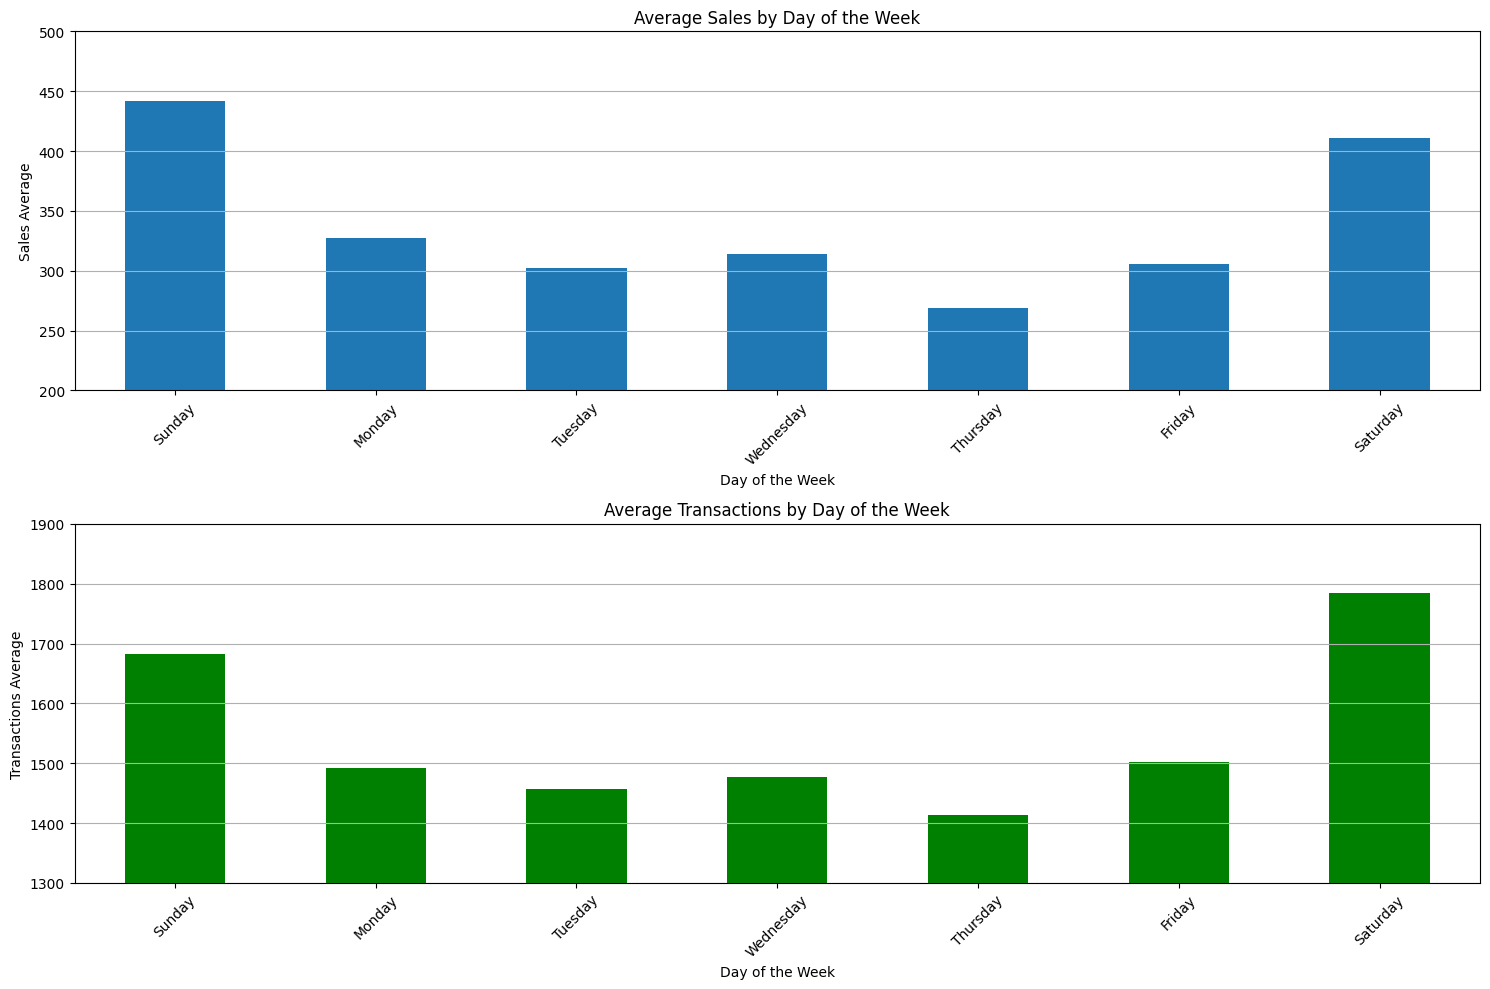

In [10]:
days_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']

train_dataset.loc[:, 'day_of_week'] = train_dataset['date'].dt.day_name().copy()
avg_sales = train_dataset.groupby('day_of_week')['sales'].mean()
avg_sales = avg_sales.reindex(days_order)
avg_transactions = train_dataset.groupby('day_of_week')['transactions'].mean()
avg_transactions = avg_transactions.reindex(days_order)

fig, axes = plt.subplots(2,1, figsize=(15, 10))

avg_sales.plot(ax=axes[0], kind='bar')
axes[0].set_title('Average Sales by Day of the Week')
axes[0].set_xlabel('Day of the Week')
axes[0].set_ylabel('Sales Average')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
axes[0].grid(axis='y')
axes[0].set_ylim(200, 500)

avg_transactions.plot(ax=axes[1], kind='bar', color='green')
axes[1].set_title('Average Transactions by Day of the Week')
axes[1].set_xlabel('Day of the Week')
axes[1].set_ylabel('Transactions Average')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
axes[1].grid(axis='y')
axes[1].set_ylim(1300, 1900)

plt.tight_layout()
plt.show()

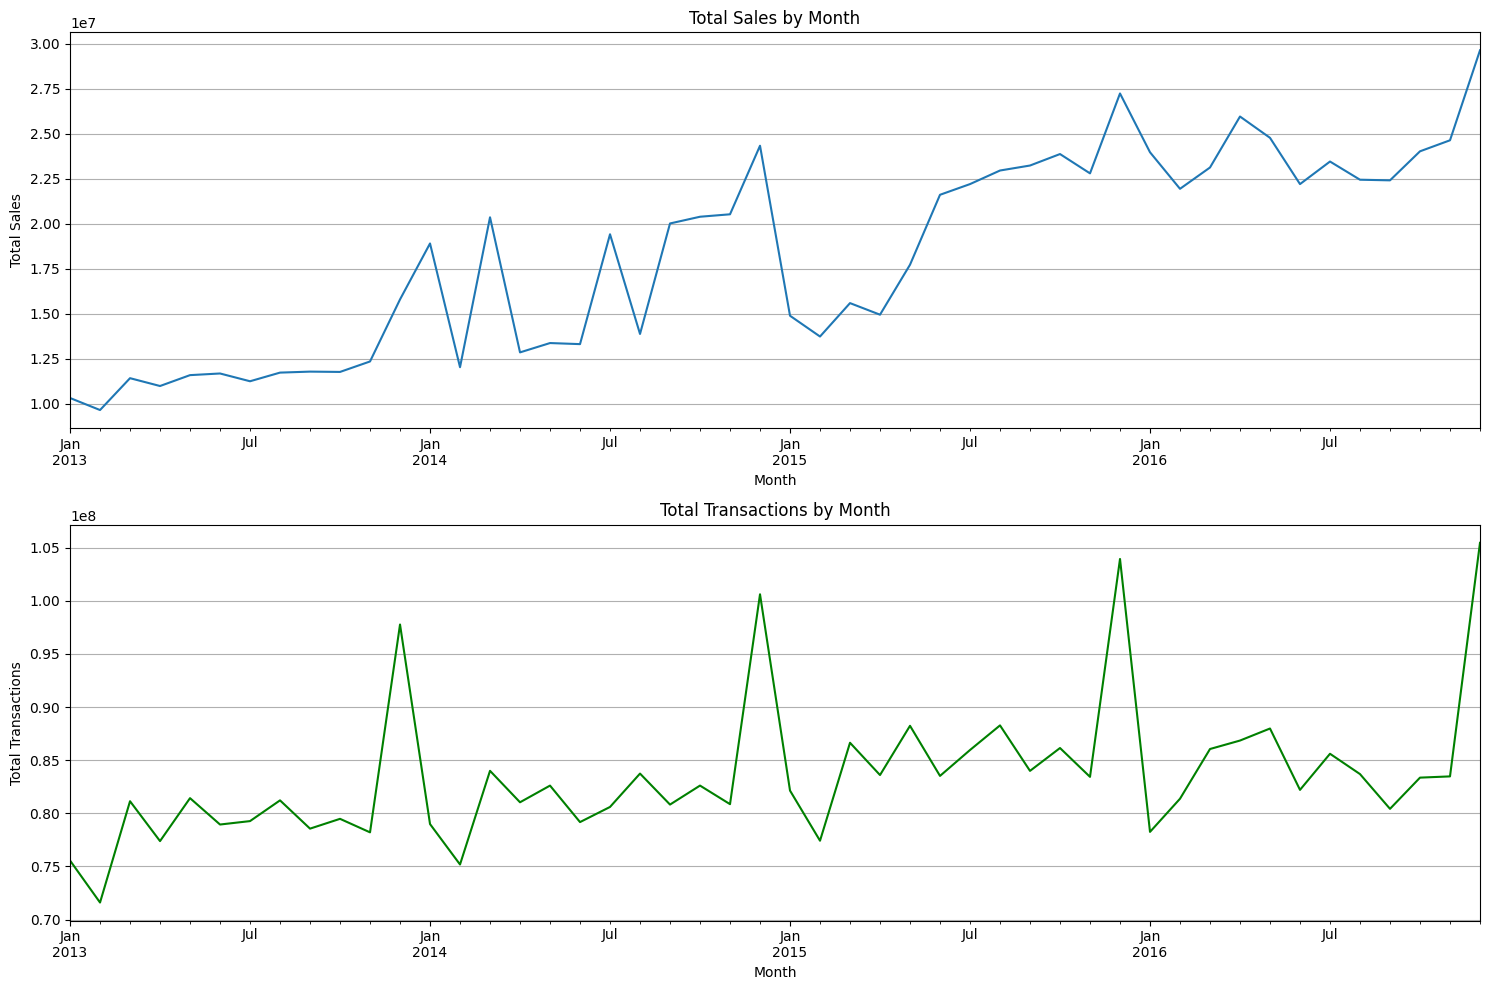

In [11]:

train_dataset.loc[:, 'month'] = train_dataset['date'].dt.to_period('M').copy()
monthly_avg_sales = train_dataset.groupby('month')['sales'].sum()
monthly_avg_transactions = train_dataset.groupby('month')['transactions'].sum()
# monthly_avg_sales = monthly_avg_sales.reindex(days_order)

fig, axes = plt.subplots(2,1, figsize=(15, 10))
monthly_avg_sales.plot(ax=axes[0], kind='line')
axes[0].set_title('Total Sales by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Sales')
axes[0].grid(axis='y')

monthly_avg_transactions.plot(ax=axes[1], kind='line', color='green')
axes[1].set_title('Total Transactions by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Transactions')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

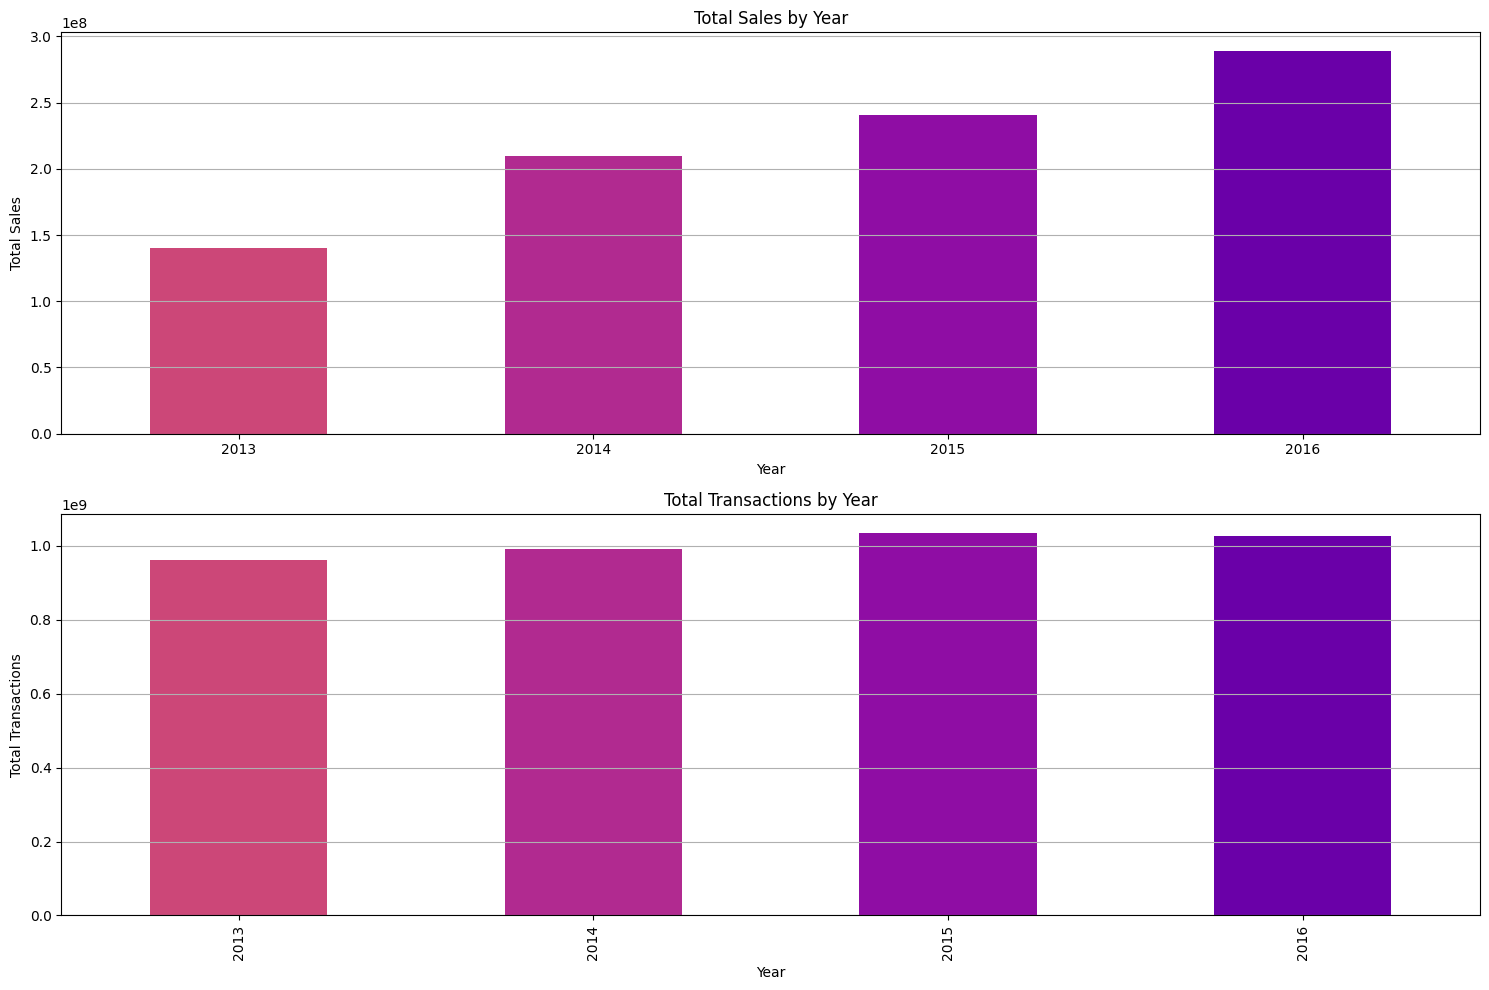

In [12]:
train_dataset['year'] = train_dataset['date'].dt.year
yearly_avg_sales = train_dataset.groupby('year')['sales'].sum()
yearly_avg_transactions = train_dataset.groupby('year')['transactions'].sum()

cmap = plt.colormaps.get_cmap('plasma')

fig, axes = plt.subplots(2,1, figsize=(15, 10))
yearly_avg_sales.plot(ax=axes[0], kind='bar', color=cmap(np.linspace(0.5, 0.2, len(yearly_avg_sales))))
axes[0].set_title('Total Sales by Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Total Sales')   
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(axis='y')

yearly_avg_transactions.plot(ax=axes[1], kind='bar',  color=cmap(np.linspace(0.5, 0.2, len(yearly_avg_sales))))
axes[1].set_title('Total Transactions by Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Total Transactions')
axes[1].grid(axis='y')

plt.tight_layout()
plt.show()

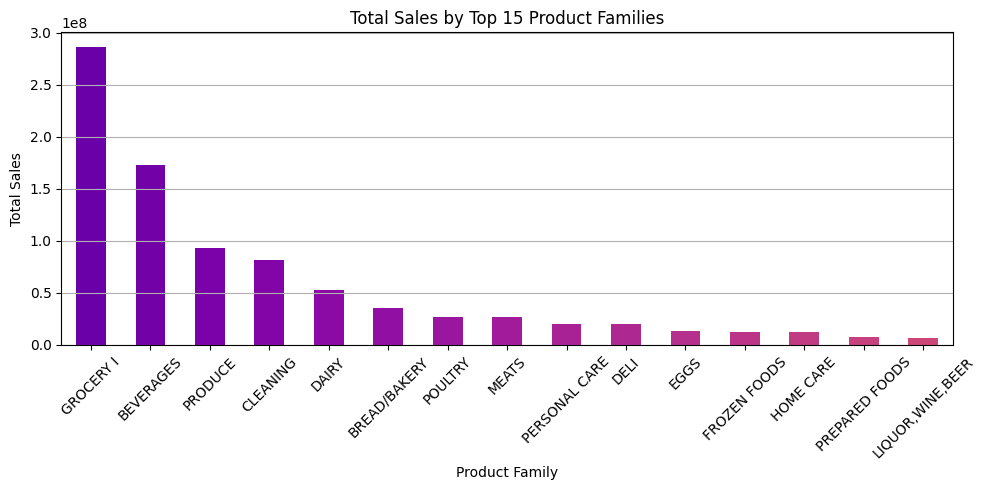

In [13]:
sales_by_product_family = train_dataset.groupby('family')['sales'].sum()
top_families = sales_by_product_family.nlargest(15)

cmap = plt.colormaps.get_cmap('plasma')

fig, ax = plt.subplots(figsize=(10, 5))
top_families.plot(ax=ax, kind='bar', color=cmap(np.linspace(0.2, 0.5, len(top_families))))

# Set titles and labels
ax.set_title('Total Sales by Top 15 Product Families')
ax.set_xlabel('Product Family')
ax.set_ylabel('Total Sales')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

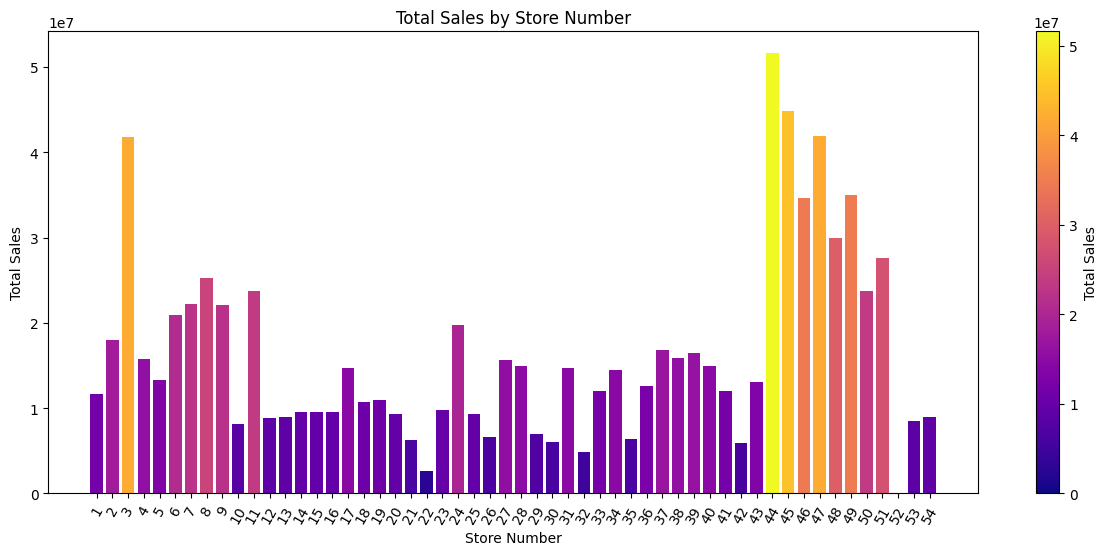

In [14]:
sales_by_store = train_dataset.groupby('store_nbr')['sales'].sum().reset_index()
sales_by_store = sales_by_store.sort_values('store_nbr')
norm = plt.Normalize(sales_by_store['sales'].min(), sales_by_store['sales'].max())

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(sales_by_store['store_nbr'], sales_by_store['sales'], color=plt.cm.plasma(norm(sales_by_store['sales'])))
ax.set_xticks(sales_by_store['store_nbr'])
ax.set_xticklabels(sales_by_store['store_nbr'], rotation=60)
plt.title('Total Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')

cax, _ = plt.cm.ScalarMappable(cmap="plasma", norm=norm), ax
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Total Sales')

plt.show()

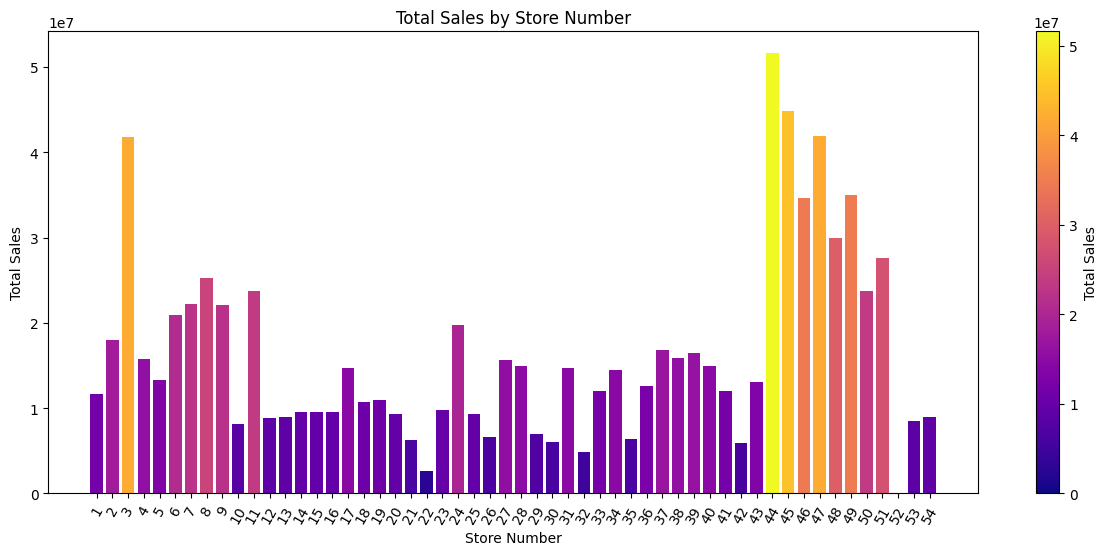

In [15]:
sales_by_store = train_dataset.groupby('store_nbr')['sales'].sum().reset_index()
sales_by_store = sales_by_store.sort_values('store_nbr')
norm = plt.Normalize(sales_by_store['sales'].min(), sales_by_store['sales'].max())

fig, ax = plt.subplots(figsize=(15, 6))
bars = ax.bar(sales_by_store['store_nbr'], sales_by_store['sales'], color=plt.cm.plasma(norm(sales_by_store['sales'])))
ax.set_xticks(sales_by_store['store_nbr'])
ax.set_xticklabels(sales_by_store['store_nbr'], rotation=60)
plt.title('Total Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Total Sales')

cax, _ = plt.cm.ScalarMappable(cmap="plasma", norm=norm), ax
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('Total Sales')

plt.show()

In [16]:
def create_columns(df: pd.DataFrame):
    df.loc[:, 'day_of_week'] = df['date'].dt.day_name()
    df.loc[:, 'month'] = df['date'].dt.month
    df.loc[:, 'year'] = df['date'].dt.year
    df.loc[:, 'day'] = df['date'].dt.day
    df.drop('date', axis=1, inplace=True)

create_columns(test_dataset)
create_columns(train_dataset)
create_columns(submission_test_dataset)

/tmp/ipykernel_44325/1954638194.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1  1  1 ... 12 12 12]' has dtype incompatible with period[M], please explicitly cast to a compatible dtype first.
  df.loc[:, 'month'] = df['date'].dt.month


In [17]:
categorical_columns = ['family', 'day_of_week']
numerical_columns = ['sales', 'transactions']
def encode_categoricals(df, categorical_cols):
    # Select the categorical columns from the dataframe
    cat_df = df[categorical_cols]
    
    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    
    # Fit and transform the encoder on the categorical data
    encoded_data = encoder.fit_transform(cat_df)
    
    # Create column names for the encoded columns
    encoded_columns = encoder.get_feature_names_out(input_features=categorical_cols)
    
    # Create a new dataframe with the encoded data and column names
    encoded_df = pd.DataFrame(encoded_data, columns=encoded_columns)
    
    # Drop the original categorical columns from the dataframe
    df = df.drop(columns=categorical_cols)
    
    # Concatenate the original dataframe with the encoded dataframe
    df_encoded = pd.concat([df, encoded_df], axis=1)
    print('ok')
    
    return df_encoded

processed_train_dataset = encode_categoricals(train_dataset, categorical_columns)
processed_test_dataset = encode_categoricals(test_dataset, categorical_columns)
processed_evaluation_dataset = encode_categoricals(submission_test_dataset, categorical_columns)

ok
ok
ok


In [18]:
y_train = processed_train_dataset['sales']
X_train = processed_train_dataset.drop('sales', axis=1)

y_test = processed_test_dataset['sales']
X_test = processed_test_dataset.drop('sales', axis=1)
print('ok')

ok


In [19]:
# Random Forest Regression Model


rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Calculate metrics
rf_mse = mean_squared_error(y_test, rf_predictions)
rf_mae = mean_absolute_error(y_test, rf_predictions)

# Apply the absolute value function to both y_test and rf_predictions
y_eval_abs = abs(y_test)
rf_predictions_abs = abs(rf_predictions)

# Calculate the Root Mean Squared Logarithmic Error (RMSLE)
rf_rmsle = np.sqrt(mean_squared_log_error(y_eval_abs, rf_predictions_abs))

# Create a DataFrame to store results for Random Forest
results_rf = pd.DataFrame({'Model': ['Random Forest'],
                            'RMSLE': [rf_rmsle],
                            'RMSE': [np.sqrt(rf_mse)],
                            'MSE': [rf_mse],
                            'MAE': [rf_mae]}).round(2)

# Print the results_rf dataframe
results_rf

: 